# Product's price prediction by nutrition values

In this project, we wanted to find the connection between the nutrition values of products and their price. we want to emphasize that we were awarded to the fact that there are other causes to a certain products' price, such as tax, where the product was produced (if it has been imported), etcetera.

Thus, we worked on the project while knowing that there might not be a full connection between the nutrition values and the price of a product, but these are the aspects we chose to focus on in our project.

We started by doing web-scraping from the website of the grocery network 'Shufersal'. https://www.shufersal.co.il/online/he/A

The goal is to create a model that accepts the nutrition values of a product and predicts its estimated price.

## Table of Contents:
####  1. Getting to know the data, train test split, initial data cleanse
####  2. Creating a new data set
####  3. Analyzing and visualizing the first data set
####  4. Choosing a metric method and checking habits of dummy-model
####  5. Sampling models (and checking with cross validation):
     -A. Linear regression
     -B. Decision tree regressor 
     -C. Random forest regressor
####  6. comparing models scores and choosing the final model
####  7. conclusion

## 1. Getting to know the data, train test split, initial data cleanse:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as MAE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False, low_memory=False)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9603 entries, 0 to 9602
Columns: 106 entries, Product_Name to Chlorophyll
dtypes: float64(81), int64(14), object(11)
memory usage: 7.8+ MB
None


,Product_Name,code,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,P_964560,5.9,0.09,0.08,1.7,24.0,47.0,9,12,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
1,Gilded_apple,P_963136,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
2,lemon,P_964492,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
3,Orange_in_the_juice_network,P_964348,4.9,0.09,0.06,2.5,39.0,49.0,1,11.9,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0
4,Avocado,P_964980,9.9,0.07,0.30,6.7,81.0,160.0,2,8.5,...,0.0,0.0,0,0,0,0.0,0.0,0,0,0


In [3]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)
prod = train_set.copy()

In [4]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('code')
prod = prod.drop_duplicates() #we figured that if there are duplicates within the data, we should drop them
prod= prod.set_index('Product_Name')

In [5]:
#in order to turn all the objects we have to numeric - float or int
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index #we wanted to save all the columns we droped, so we could drop them in the test set as well
prod = prod.loc[:, (prod != 0).any(axis=0)]
prod.info() #in order to see that we scceeded and to have a look at the columns

<class 'pandas.core.frame.DataFrame'>
Index: 6482 entries, Stevia_sucrose_300_tablets to Chocolate_Granola_Crunch
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 6482 non-null   float64
 1   Vitamin_B1                           6482 non-null   float64
 2   Vitamin_B6                           6482 non-null   float64
 3   Dietary_fiber                        6482 non-null   float64
 4   Folic_acid                           6482 non-null   float64
 5   energy                               6482 non-null   float64
 6   Proteins                             6482 non-null   float64
 7   Carbohydrates                        6482 non-null   float64
 8   Fats                                 6482 non-null   float64
 9   sodium                               6482 non-null   float64
 10  Vitamin_B3                           6482 non-null   flo

### After a brief look at the columns we have, we pointed out a couple of things that needed to be done:
##### Get rid of the unwanted units we have:
we want the get rid of all the products that are not measured by 100_g or 1_kg (and delete the rows of these units).
afterward, we need to unite the 100_g and 1_kg units (by dividing 1_kg by 10 we'll get the price for 100_g).
#### we'll check which columns are left, and with them:
##### Unite the columns:
- DHA_fatty_acid and DHA 
- A_vitamin and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium, and Vitamin_b3 (they are referring to the same thing: https://en.wikipedia.org/wiki/Niacin)
- sodium and Chloride
- DHA and EPA with DHA_+_EPA (?)

##### Look at features we suspect may have a high correlation:
- Vitamin b's group
- all the things that contain sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [6]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index) #as excpected, there aren't products like these, a.k.a - the scraping did it's job well
#we want to remove the products without the wanted price units
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index #again, we wanted to save all the columns we droped, so we could drop them in the test set as well
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10 #transfering the units
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index([], dtype='object', name='Product_Name')


In [7]:
#in order to reduce background noise, we decided to drop the columns in which there are less than 20 products with this feature
prod = prod.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in prod.columns:
    if prod[col].astype(bool).sum(axis=0)<20: #all the features that less than a third precent of the products have
        arr = np.append(arr, prod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col) #saved the columns we droped in order to drop from test set
arr = set(arr) #all number of rows without duplicates
for i in arr:
    prod = prod.drop(i) #droping the products who had these columns for the chance that the nutrition value might have had an integral part in the pricing of the product
prod = prod.drop(col_droped, axis=1)
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero
prod = prod.set_index(['Product_Name'])

In [8]:
print(sts_dropped_collumns) #columns that were droped due to being all zeros at the beginning
print(all_dropped_collumns) #columns that were droped due to being all zeros after droping products measured by unwanted units
print(col_droped) #columns that were droped due to having less than 20 non-zero values

Index(['Non-fibrous_fibers', 'wetness', 'ash', 'Sucrose', '1_meter',
       '100_meters'],
      dtype='object')
Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Acetic_acid', 'Unsaturated',
       'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA', 'Chlorophyll'],
      dtype='object')
['Monounsaturated_fat' 'Polyunsaturated_fat' 'Reduced_sodium' 'Lactose'
 'From_the_carbohydrates_lactose' 'Vitamin_D_Calciprolol' 'caffeine'
 'Fat_without_trans' 'Pantothenic_acid' 'Trans_fat'
 'Of_which_unsaturated_fat' '6_omega_fatty_acids'
 'From_sugars_to_organic_acids' 'Salt' 'Lycopene' 'Soluble_fiber'
 'Oleic_fatty_acids' 'K_Potassium' 'starch' 'Linoleic_fatty_acid.1'
 'Lutein' 'Galactooligosaccharides' 'Chloride' 'AA_fatty_acid'
 'Vitamin_B3_Nicotinamide_Equilibrium' 'humidity' 'chromium' 'Molybdenum']


noticed that Chloride DHA, EPA, and DHA_+_EPA columns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### Unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- A_vitamin and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- sodium and Chloride~~

~~- DHA and EPA with DHA_+_EPA (?)~~

##### Look at features we suspect may have a high correlation:
- Vitamin b's group
- all the things that contain sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to work on the feature in the data set comfortably, so we split the prices from the nutrition values. Then, we created another train and test set based on how many products have values in each column, because logically, the nutrition values we have more can help us predict the price to a wider range of products.

In [9]:
products = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

## 2. creating a new data set, scaling:

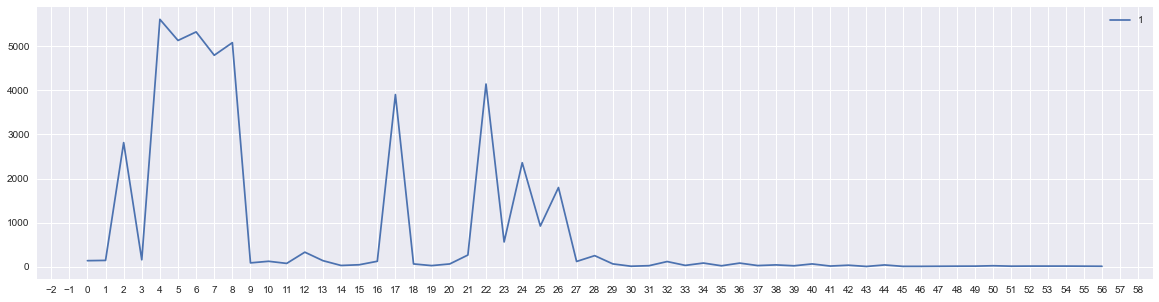

In [10]:
df_num = []
df_name = []
for col in products.columns:
    df_num.append(int(products[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Set a tick on each integer multiple of a base within the view interval.
plta.gcf().set_size_inches(20, 5)
plta.show() # to check which features can be given up
#it seems that starting from feature number 27, we can give up on all of the features
#it makes sense because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is to prevent doing overfitting)

In the end, when we tried to run the models we decided what kind of filtering is the most worthy, and which features are better for predictions (what feature selection we should do).

In [11]:
products2 = products.iloc[:,2:26] #we created the second dataset we wanted. We put it aside for a while.
prices2 = prices.copy()

## 3.Analyzing and visualizing the first data set:

### Uniting the desired columns:

In [12]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns: #checks if both columns exist in the data frame
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]: #running on the values in the column
            if (prod==0):
                if (dataframe.at[row , col2]!=0): 
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [13]:
#we united the columns we set as a goal to unite in the beginning
products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Nicotinamide', products, 'Product_Name')

### Checking the correlations:

###### Checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamin is that they are often appear together in the same types of food. 

Hence, we'll try to find a correlation between the different types of vitamin B, to unite them all under one column - the Vitamin B group.

<AxesSubplot:>

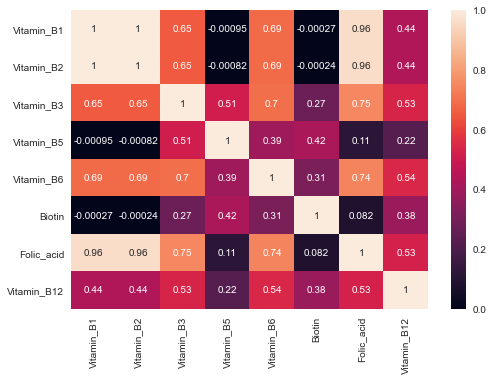

In [14]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the matrix, we concluded that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6, or Vitamin_B9 (Folic_acid). 

We chose them by the number of correlations that are about>=0.8 (we didn't consider Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of the columns it will be by these criteria:
- the one with the higher correlations
- the one with the least lower correlations
- the one with the biggest correlation with the column we want to predict - price_per_100g

In [15]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B6', 'Folic_acid', 'Vitamin_B3']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  3
Vitamin_B1 : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Vitamin_B1 :  0.01483395014538757
Vitamin_B6 : number of correlations that are greater than 0.8:  1
Vitamin_B6 : number of correlations that are below or equal 0.2:  0
correlation between price_per_100g and  Vitamin_B6 :  0.017528729289519675
Folic_acid : number of correlations that are greater than 0.8:  3
Folic_acid : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Folic_acid :  0.014920251899455493
Vitamin_B3 : number of correlations that are greater than 0.8:  1
Vitamin_B3 : number of correlations that are below or equal 0.2:  0
correlation between price_per_100g and  Vitamin_B3 :  0.012713243075675774


By the two first criteria we have put first, it seems that the columns we should take as a representative for the Vitamin B group are the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 4), and it has the smallest number of correlations that are below or equal 0.2 (which is 1). It has, as well, the biggest correlation with price_per_100g.

we tried as well a different approach - instead of choosing one column to be the representative of the vitamin B group, we tried to merge between the different Vitamin Bs. we gave more significance to Vitamin_B6 and the ones that were designated to be the representatives by this order: first Vitamin_B6, then Vitamin_B9 (Folic_acid) (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well), After Vitamin_B1, and then Vitamin_B3, the last of the might_be_rep. Then there was be Vitamin_B12, which has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal to 0.2. And last but not least were Vitamin_B5 and Biotin, because we can see from the graph that Vitamin_B5 has the best higher correlationsand the Biotin the seconds.

we tried different combinations of the code that appears in the next window, but it seemed that no matter what we did, the correlation between the column we tried to create to the price_per_100g stayed the same.

In the end, we decided to stick with the Vitamin_B6 as the representer of this group, except for Vitamin_B5 and Biotin who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [16]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid','Vitamin_B3'], axis=1)

In [17]:
corr_matrix5 = products.corr()
corr_matrix5['Vitamin_B5'].sort_values(ascending=False).head(10)
#the only connection found - between copper and b5: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Biotin                  0.420944
Partof_vitaminB         0.391221
Vitamin_E.              0.346967
Ascorbic_acid           0.230463
iron                    0.181558
calcium                 0.152946
Inositol                0.099583
Alpha_linolenic_acid    0.098187
Choline                 0.092783
Name: Vitamin_B5, dtype: float64

In [18]:
corr_matrix7 = products.corr()
corr_matrix7['Biotin'].sort_values(ascending=False).head(10)
#The only connection found - between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                  1.000000
Vitamin_E.              0.519854
Vitamin_B5              0.420944
Partof_vitaminB         0.313915
Vitamin_C               0.206431
Ascorbic_acid           0.205626
Many_alcohols           0.103906
Choline                 0.061385
Alpha_linolenic_acid    0.060402
Inositol                0.058095
Name: Biotin, dtype: float64

As we saw, the highest correlation Vitamin_B5 has is with Biotin, and Biotin's highest correlation is with Vitamin E. We couldn't find a reason for that connection between them, except for the fact that They are water-soluble, which means that the body can't store them. (https://medlineplus.gov/ency/article/002410.htm)

Furthermore, because we did find a representative of the majority of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

<AxesSubplot:>

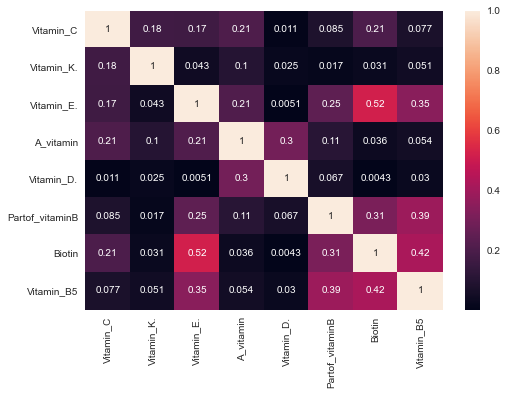

In [19]:
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','A_vitamin','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
sns.heatmap(corrvl, annot=True)

There isn't a particularly high correlation. There is a weak connection between a couple of them, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### Checking correlations between all the things that contain sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

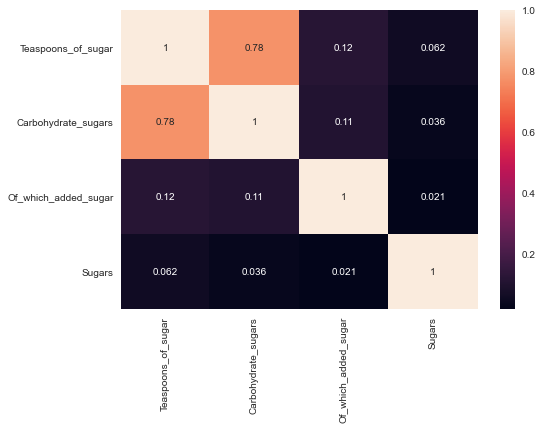

In [20]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph, we saw that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, because as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Then, we checked the correlation between Teaspoons_of_sugar, Carbohydrate_sugars, and price_per_100g (to decide on which of the two columns we should give up), but before the decision to drop the Carbohydrate sugars column, we checked as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [21]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4717630795532197


The correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [22]:
products = merge_two_columns('Carbohydrate_sugars', 'Teaspoons_of_sugar', products, 'Product_Name')

###### Checking correlations between energy and the rest of the nutrition values:

In [23]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False).head(10))

energy                    1.000000
Fats                      0.764134
Carbohydrates             0.447230
Carbohydrate_sugars       0.373108
Dietary_fiber             0.206851
iron                      0.130335
Proteins                  0.109047
Cholesterol               0.097189
Of_which_saturated_fat    0.090443
Trans_fatty_acids         0.089501
Name: energy, dtype: float64


The strong correlation between "energy" and "Fats" is high, because as we found at Wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 .

In [24]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)

correlation with energy  0.06417800362347297
correlation with Fats  0.10010431026974562


The correlation between Fats and the price is higher than The correlation between energy and the price. Thus, we decided to merge the energy column into the Fats column.

In [25]:
products = merge_two_columns('Fats', 'energy', products, 'Product_Name')

###### Checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fatty acid. In their compound, Linoleic_fatty_acid has 2 more hydrogens than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

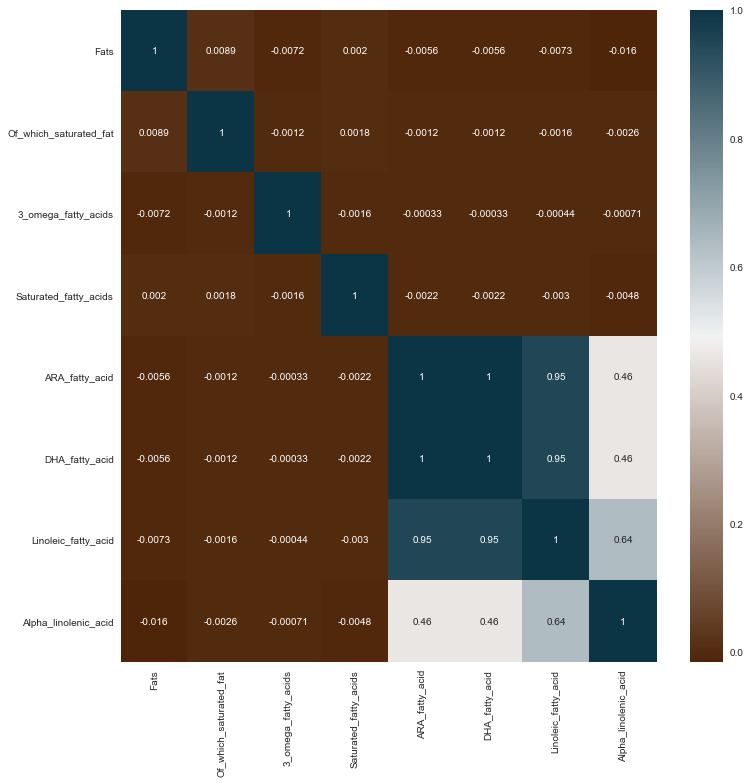

In [26]:
Ft = ['Fats','Of_which_saturated_fat','3_omega_fatty_acids','Saturated_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid']
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from the graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid, and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further into the origins of ARA_fatty_acid. 

we found out that Linoleic acid, ARA_fatty_acid are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we discovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [27]:
products['6_omega_fatty_acids'] = products['ARA_fatty_acid']
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

After that, we wanted to check the correlation matrix of all the features that have been left, to see if there's anything else worth checking(a.k.a merging or dropping).

<AxesSubplot:>

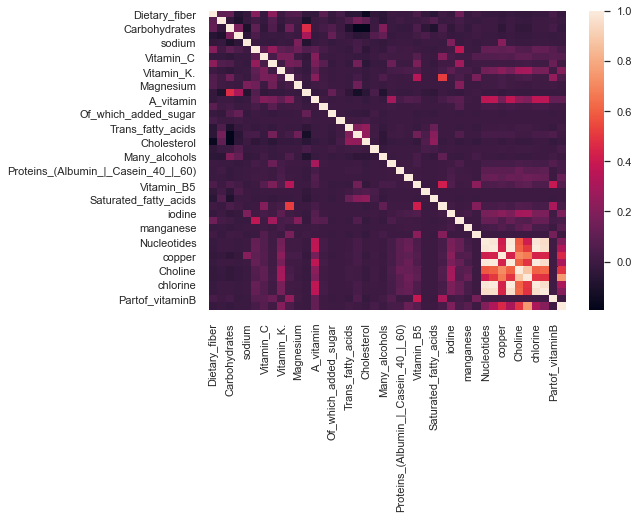

In [28]:
corr_matrix = products.corr()
sns.heatmap(corr_matrix) 

We noticed that Nucleotides has a couple of high correlations, so we decided to check that out.

In [29]:
print(corr_matrix["Nucleotides"].sort_values(ascending=False).head(15))

Nucleotides            1.000000
Taurine                0.988346
chlorine               0.985213
selenium               0.982009
Carnitine              0.953808
Choline                0.584505
Inositol               0.414225
copper                 0.412894
A_vitamin              0.364483
6_omega_fatty_acids    0.201507
iodine                 0.168035
Vitamin_K.             0.155641
phosphorus             0.122284
3_omega_fatty_acids    0.121426
potassium              0.114474
Name: Nucleotides, dtype: float64


We found that the high correlation between Nucleotides, Choline, and Taurine can be explained by the fact that they are all are very popular in baby food (https://www.cfs.gov.hk/english/multimedia/multimedia_pub/multimedia_pub_fsf_81_02.html), so we decided to merge these three nutrition values into one column.

other than that we weren't able to find any more explanations for the high correlations, but we did find interesting connections between a couple of the nutrition values, attached for your reference:

(found a connection between taurine on the toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420

found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/

found rate studies of the destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

we have consulted with a chimist but the only big connection was between the molecular structure of Vitamin_A and 6_omega_fatty_acids and the fact that they are both dissolved in fat / both fatty).

In [30]:
products['have_to_do_with_milk'] = products['Nucleotides'] 
products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Choline', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Taurine', products, 'Product_Name')

For the last cleaning, before going into testing models, we wanted to search if there are columns we can merge in the second data set that we have already merged in the first one.

In [31]:
products2.columns

Index(['Dietary_fiber', 'Folic_acid', 'energy', 'Proteins', 'Carbohydrates',
       'Fats', 'sodium', 'Vitamin_B3', 'potassium', 'Vitamin_C', 'iron',
       'Vitamin_B2', 'Vitamin_K.', 'Vitamin_E.', 'Magnesium',
       'Carbohydrate_sugars', 'A_vitamin', 'Dietary_fiber.1', 'zinc',
       'Of_which_added_sugar', 'Of_which_saturated_fat', 'Trans_fatty_acids',
       'Teaspoons_of_sugar', 'calcium'],
      dtype='object')

There was indeed a few merges we have already done in the first data set, so we did them as well on the second.

In [32]:
products2 = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products2, 'Product_Name')
products2 = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', products2, 'Product_Name')
products2 = merge_two_columns('Fats', 'energy', products2, 'Product_Name')

## 4. Choosing a metric method and checking habits of dummy-model: 

After we accomplished all of our goals from the beginning and by that prepared the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measures.

Three error metrics are commonly used for evaluating and reporting the performance of a regression model; they are:

Mean Squared Error (MSE).
Root Mean Squared Error (RMSE).
Mean Absolute Error (MAE).


Mean Squared Error, or MSE for short is a popular error metric for regression problems.

It is also an important loss function for algorithms fit or optimized using the least-squares framing of a regression problem. Here “least squares” refers to minimizing the mean squared error between predictions and expected values.

The MSE is calculated as the mean or average of the squared differences between predicted and expected target values in a dataset.

MSE = 1 / N * sum for i to N (y_i – yhat_i)^2

The squaring also has the effect of inflating or magnifying large errors. That is, the larger the difference between the predicted and expected values, the larger the resulting squared positive error. This has the effect of “punishing” models more for larger errors when MSE is used as a loss function. It also has the effect of “punishing” models by inflating the average error score when used as a metric.



The Root Mean Squared Error, or RMSE, is an extension of the mean squared error.

Importantly, the square root of the error is calculated, which means that the units of the RMSE are the same as the original units of the target value that is being predicted.


The RMSE can be calculated as follows:

RMSE = sqrt(1 / N * sum for i to N (y_i – yhat_i)^2)
Where y_i is the i’th expected value in the dataset, yhat_i is the i’th predicted value, and sqrt() is the square root function.

We can restate the RMSE in terms of the MSE as:

RMSE = sqrt(MSE)
While MSE uses the square operation to remove the sign of each error value and to punish large errors, the square root reverses this operation, although it ensures that the result remains positive.



Mean Absolute Error, or MAE, is a popular metric because, like RMSE, the units of the error score match the units of the target value that is being predicted.

Unlike the RMSE, the changes in MAE are linear and therefore intuitive.

That is, MSE and RMSE punish larger errors more than smaller errors, inflating or magnifying the mean error score. This is due to the square of the error value. The MAE does not give more or less weight to different types of errors and instead the scores increase linearly with error increases.

The MAE can be calculated as follows:

MAE = 1 / N * sum for i to N abs(y_i – yhat_i)
Where y_i is the i’th expected value in the dataset, yhat_i is the i’th predicted value and abs() is the absolute function.

source - (https://machinelearningmastery.com/regression-metrics-for-machine-learning/)

we decided to measure our project by MAE be. because our model can be easily affected by outliers and MAE is neutralizing them best as possible. Also, it is considered an excellent general-purpose error metric for numerical predictions.

what we did next was to create a function that is functioning as a pipeline (doing a series of orders by order), to prepare new data coming.
Then we checked the dummy regressor score.

In [33]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12','Vitamin_B3'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] 
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [34]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_products = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [35]:
test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [36]:
test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [37]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mae = MAE(test_set_prices1, predictdum1)
print( "Dummy Regressor mean absolute error of " + str(mae)[:4])

Dummy Regressor mean absolute error of 4.05


In [38]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products2, prices2)
predictdum2 = dummy_regr.predict(test_set_prod2)
mae = MAE(test_set_prices2, predictdum2)
print( "Dummy Regressor mean absolute error of " + str(mae)[:4])

Dummy Regressor mean absolute error of 4.05


## 5. Sampling models (and checking with cross validation):

For each model we tried to find every parameter's importance by Feature Importance and by tried to fine-tune our models: (source - https://machinelearningmastery.com/calculate-feature-importance-with-python/)

## A. Linear regression

Linear regression is a model that tries to find a linear connection between all the features that has been given to it.

In [39]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

lin_reg = LinearRegression()
predict1 = cross_val_predict(lin_reg, products, prices, cv=kf)
mae_linreg1 = MAE(prices, predict1)
print(mae_linreg1)

predict2 = cross_val_predict(lin_reg, products2, prices2, cv=kf)
mae_linreg2 = MAE(prices2, predict2)
print(mae_linreg2)

4.079118062432108
6.693721001307138


we noticed that the MAE of the second version of the data set in the linear regression much bigger than the dummy model, and it does not make sense. We looked through the values that the model gives to each product and found an outlier. After removing it, another outlier popped up. We couldn't explain the appearance of the outliers except for the fact that linear regression is not suitable for the task (even for the first data set, its score is worse than the dummy model's score).

Feature: 0, Score: 0.10681
Feature: 1, Score: 0.00326
Feature: 2, Score: -0.02810
Feature: 3, Score: 0.00002
Feature: 4, Score: 0.00011
Feature: 5, Score: -0.00437
Feature: 6, Score: -0.04817
Feature: 7, Score: -0.06598
Feature: 8, Score: -0.11700
Feature: 9, Score: 0.60241
Feature: 10, Score: -0.00043
Feature: 11, Score: 0.05707
Feature: 12, Score: -0.00183
Feature: 13, Score: -0.01772
Feature: 14, Score: -0.06868
Feature: 15, Score: 0.00104
Feature: 16, Score: 0.12878
Feature: 17, Score: 0.00080
Feature: 18, Score: 0.01007
Feature: 19, Score: -0.10683
Feature: 20, Score: 0.15424
Feature: 21, Score: -0.03020
Feature: 22, Score: 0.04799
Feature: 23, Score: 0.00328
Feature: 24, Score: 0.09433
Feature: 25, Score: 0.08449
Feature: 26, Score: -0.01059
Feature: 27, Score: -0.14687
Feature: 28, Score: -0.01369
Feature: 29, Score: -0.00008
Feature: 30, Score: -0.00903
Feature: 31, Score: -0.02145
Feature: 32, Score: 0.47026
Feature: 33, Score: -0.07002
Feature: 34, Score: 1.15338
Feature: 35,

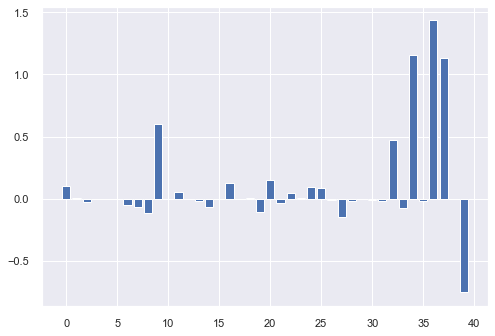

Feature: 9, Score: 0.60241
Feature: 32, Score: 0.47026
Feature: 34, Score: 1.15338
Feature: 36, Score: 1.43448
Feature: 37, Score: 1.13413
Feature: 39, Score: -0.75095


In [40]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products, prices)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.3:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [41]:
productsv = products.iloc[:,listm]
predict = cross_val_predict(lin_reg, productsv, prices, cv=kf)
mae_linreg1_v2 = MAE(prices, predict)
print(mae_linreg1_v2)

4.163321575697188


Feature: 0, Score: 0.06528
Feature: 1, Score: 0.00785
Feature: 2, Score: -0.00087
Feature: 3, Score: -0.00568
Feature: 4, Score: 0.00334
Feature: 5, Score: 0.00008
Feature: 6, Score: -0.24361
Feature: 7, Score: -0.00459
Feature: 8, Score: -0.04672
Feature: 9, Score: -0.07645
Feature: 10, Score: -0.00263
Feature: 11, Score: -0.08172
Feature: 12, Score: 0.20733
Feature: 13, Score: -0.00051
Feature: 14, Score: 0.00045
Feature: 15, Score: -0.02034
Feature: 16, Score: -0.07132
Feature: 17, Score: 0.00129
Feature: 18, Score: 0.25146
Feature: 19, Score: 0.01924
Feature: 20, Score: 0.00135


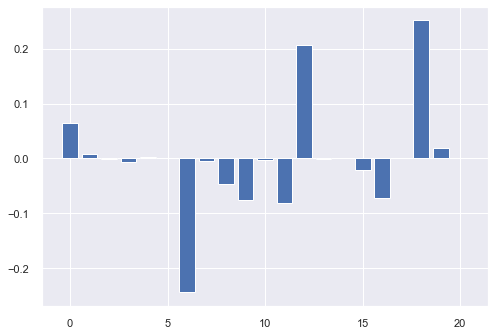

Feature: 0, Score: 0.06528
Feature: 1, Score: 0.00785
Feature: 3, Score: -0.00568
Feature: 6, Score: -0.24361
Feature: 8, Score: -0.04672
Feature: 9, Score: -0.07645
Feature: 11, Score: -0.08172
Feature: 12, Score: 0.20733
Feature: 15, Score: -0.02034
Feature: 16, Score: -0.07132
Feature: 18, Score: 0.25146
Feature: 19, Score: 0.01924


In [42]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products2, prices2)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm2 =[]
for i,v in enumerate(importance):
    if abs(v)>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [43]:
productsv2 = products.iloc[:,listm]
predict2 = cross_val_predict(lin_reg, productsv2, prices2, cv=kf)
mae_linreg2_v2 = MAE(prices, predict2)
print(mae_linreg2_v2)

4.255133922524798


Although feature selection did help with improving the scores of both models, their scores were still not good, so we tried other models.

## B. Decision tree regressor

Decision tree regressor is a model that creates a binary tree based on a threshold and a feature that creates an optimal tree.

In [44]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
treereg_score1 = MAE(prices, predicttree1)
print(treereg_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
treereg_score2 = MAE(prices2, predicttree2)
print(treereg_score2)

2.7566638137009187
2.8385068504594817


Feature: 0, Score: 0.02353
Feature: 1, Score: 0.02752
Feature: 2, Score: 0.05028
Feature: 3, Score: 0.06550
Feature: 4, Score: 0.31654
Feature: 5, Score: 0.00026
Feature: 6, Score: 0.00002
Feature: 7, Score: 0.00171
Feature: 8, Score: 0.00015
Feature: 9, Score: 0.00554
Feature: 10, Score: 0.00025
Feature: 11, Score: 0.09426
Feature: 12, Score: 0.00094
Feature: 13, Score: 0.00041
Feature: 14, Score: 0.00196
Feature: 15, Score: 0.35830
Feature: 16, Score: 0.00217
Feature: 17, Score: 0.00629
Feature: 18, Score: 0.00961
Feature: 19, Score: 0.00006
Feature: 20, Score: 0.03372
Feature: 21, Score: 0.00003
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00002
Feature: 24, Score: 0.00002
Feature: 25, Score: 0.00001
Feature: 26, Score: 0.00012
Feature: 27, Score: 0.00005
Feature: 28, Score: 0.00038
Feature: 29, Score: 0.00002
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00018
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

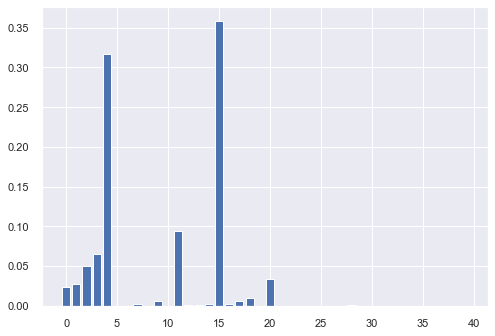

Feature: 0, Score: 0.02353
Feature: 1, Score: 0.02752
Feature: 2, Score: 0.05028
Feature: 3, Score: 0.06550
Feature: 4, Score: 0.31654
Feature: 9, Score: 0.00554
Feature: 11, Score: 0.09426
Feature: 15, Score: 0.35830
Feature: 17, Score: 0.00629
Feature: 18, Score: 0.00961
Feature: 20, Score: 0.03372


In [45]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products, prices)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi = []
for i,v in enumerate(importance):
    if v>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi.append(i)

In [46]:
products_3 = products.iloc[:,listi]
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products_3, prices, cv=kf)
treereg_score1_v2 = MAE(prices, predicttree1)
print(treereg_score1_v2)

2.7894841979949874


Feature: 0, Score: 0.02719
Feature: 1, Score: 0.00447
Feature: 2, Score: 0.05006
Feature: 3, Score: 0.06108
Feature: 4, Score: 0.06804
Feature: 5, Score: 0.32054
Feature: 6, Score: 0.00011
Feature: 7, Score: 0.00059
Feature: 8, Score: 0.00018
Feature: 9, Score: 0.00205
Feature: 10, Score: 0.00004
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00074
Feature: 14, Score: 0.00001
Feature: 15, Score: 0.00029
Feature: 16, Score: 0.00200
Feature: 17, Score: 0.04106
Feature: 18, Score: 0.00262
Feature: 19, Score: 0.41560
Feature: 20, Score: 0.00332


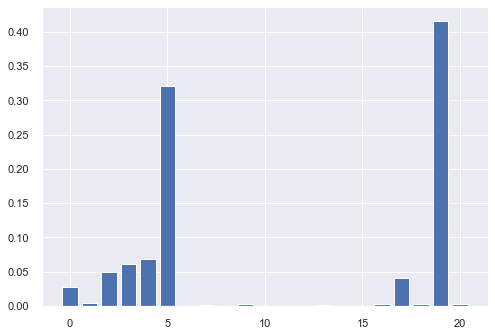

Feature: 2, Score: 0.05006
Feature: 3, Score: 0.06108
Feature: 4, Score: 0.06804
Feature: 5, Score: 0.32054
Feature: 19, Score: 0.41560


In [47]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products2, prices2)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi2 = []
for i,v in enumerate(importance):
    if v>0.05:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi2.append(i)

In [48]:
products2_3 = products.iloc[:,listi2]
tree_reg = DecisionTreeRegressor()

predicttree2 = cross_val_predict(tree_reg, products2_3, prices2, cv=kf)
treereg_score2_v2 = MAE(prices2, predicttree2)
print(treereg_score2_v2)

3.399632371634214


On this model, the scores were a bit better, but we wanted to try and make the model even better!

## C. Random forest regressor

Random forest regressor is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [49]:
random_for = RandomForestRegressor()

prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
maefor1 = MAE(prices, prodicrfor1)
print(maefor1)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
maefor2 = MAE(prices, prodicrfor2)
print(maefor2)

2.4283033988751677
2.4706222014023016


Feature: 0, Score: 0.08358
Feature: 1, Score: 0.08824
Feature: 2, Score: 0.08126
Feature: 3, Score: 0.13467
Feature: 4, Score: 0.32873
Feature: 5, Score: 0.00048
Feature: 6, Score: 0.00065
Feature: 7, Score: 0.00298
Feature: 8, Score: 0.00008
Feature: 9, Score: 0.00432
Feature: 10, Score: 0.00079
Feature: 11, Score: 0.10027
Feature: 12, Score: 0.00037
Feature: 13, Score: 0.00030
Feature: 14, Score: 0.00206
Feature: 15, Score: 0.11234
Feature: 16, Score: 0.00269
Feature: 17, Score: 0.00511
Feature: 18, Score: 0.01540
Feature: 19, Score: 0.00028
Feature: 20, Score: 0.03118
Feature: 21, Score: 0.00009
Feature: 22, Score: 0.00002
Feature: 23, Score: 0.00015
Feature: 24, Score: 0.00017
Feature: 25, Score: 0.00012
Feature: 26, Score: 0.00043
Feature: 27, Score: 0.00021
Feature: 28, Score: 0.00024
Feature: 29, Score: 0.00013
Feature: 30, Score: 0.00001
Feature: 31, Score: 0.00177
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

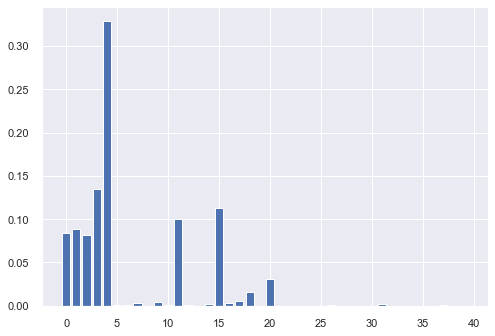

Feature: 0, Score: 0.08358
Feature: 1, Score: 0.08824
Feature: 2, Score: 0.08126
Feature: 3, Score: 0.13467
Feature: 4, Score: 0.32873
Feature: 11, Score: 0.10027
Feature: 15, Score: 0.11234
Feature: 18, Score: 0.01540
Feature: 20, Score: 0.03118


In [50]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products, prices)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listo = []
for i,v in enumerate(importance):
    if v>0.009:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listo.append(i)

In [51]:
products_2 = products.iloc[:,listo]

random_for = RandomForestRegressor()
prodicrfor = cross_val_predict(random_for, products_2, prices, cv=kf)
maefor1_v2 = MAE(prices, prodicrfor)
print(maefor1_v2)

2.4218212807679205


Feature: 0, Score: 0.05717
Feature: 1, Score: 0.00364
Feature: 2, Score: 0.11300
Feature: 3, Score: 0.10086
Feature: 4, Score: 0.13806
Feature: 5, Score: 0.31300
Feature: 6, Score: 0.00032
Feature: 7, Score: 0.00038
Feature: 8, Score: 0.00059
Feature: 9, Score: 0.00268
Feature: 10, Score: 0.00429
Feature: 11, Score: 0.00009
Feature: 12, Score: 0.00062
Feature: 13, Score: 0.00066
Feature: 14, Score: 0.00029
Feature: 15, Score: 0.00023
Feature: 16, Score: 0.00186
Feature: 17, Score: 0.12638
Feature: 18, Score: 0.00411
Feature: 19, Score: 0.12547
Feature: 20, Score: 0.00628


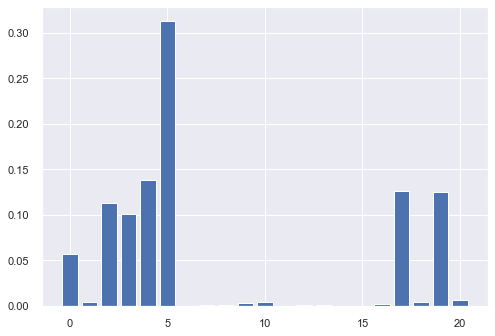

Feature: 0, Score: 0.05717
Feature: 2, Score: 0.11300
Feature: 3, Score: 0.10086
Feature: 4, Score: 0.13806
Feature: 5, Score: 0.31300
Feature: 17, Score: 0.12638
Feature: 19, Score: 0.12547
Feature: 20, Score: 0.00628


In [52]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products2, prices2)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listo2 = []
for i,v in enumerate(importance):
    if v>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listo2.append(i)

In [53]:
products2_2 = products.iloc[:,listo2]

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2_2, prices2, cv=kf)
maefor2_v2 = MAE(prices2, prodicrfor2)
print(maefor2_v2)

2.749095041524652


## 6. Comparing models scores and choosing the final model:

In [54]:
print("Before Feature Importance, Linear regression mean absolute error is:")
print()
print("Data set 1: ", mae_linreg1, ", Data set 2: ", mae_linreg2)
print('\n')
print("After Feature Importance, Linear regression mean absolute error is:")
print()
print("Data set 1: ", mae_linreg1_v2, ", Data set 2: ", mae_linreg2_v2)

Before Feature Importance, Linear regression mean absolute error is:

Data set 1:  4.079118062432108 , Data set 2:  6.693721001307138


After Feature Importance, Linear regression mean absolute error is:

Data set 1:  4.163321575697188 , Data set 2:  4.255133922524798


In [55]:
print("Before Feature Importance, Decision tree regressor mean absolute error is:")
print()
print("Data set 1: ", treereg_score1, ", Data set 2: ", treereg_score2)
print('\n')
print("After Feature Importance, Decision tree regressor mean absolute error is:")
print()
print("Data set 1: ", treereg_score1_v2, ", Data set 2: ", treereg_score2_v2)

Before Feature Importance, Decision tree regressor mean absolute error is:

Data set 1:  2.7566638137009187 , Data set 2:  2.8385068504594817


After Feature Importance, Decision tree regressor mean absolute error is:

Data set 1:  2.7894841979949874 , Data set 2:  3.399632371634214


In [56]:
print("Before Feature Importance, Random forest regressor mean absolute error is:")
print()
print("Data set 1: ", maefor1, ", Data set 2: ", maefor2)
print('\n')
print("After Feature Importance, Random forest regressor mean absolute error is:")
print()
print("Data set 1: ", maefor1_v2, ", Data set 2: ", maefor2_v2)

Before Feature Importance, Random forest regressor mean absolute error is:

Data set 1:  2.4283033988751677 , Data set 2:  2.4706222014023016


After Feature Importance, Random forest regressor mean absolute error is:

Data set 1:  2.4218212807679205 , Data set 2:  2.749095041524652


In [57]:
print("Dummy regressor mean squared error is:", str(mae)[:4])

Dummy regressor mean squared error is: 4.05


From the comparison above we can conclude that our best model is Random Forest regressor with the second version of data set number 1 (each time we ran the project, the difference between the mistakes of version 1 and 2 of the first data set were close to each other, although every time another one of them was with a bigger mistake, due to the nature of the model).
Because the errors are close to each other, we will prefer the version of the model with fewer features.

In [58]:
def final_data_preperation(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('code')
    dataw = dataw.drop_duplicates()
    dataw = dataw.set_index('Product_Name')
    
    dataw = dataw.drop_duplicates()
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products= dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12','Vitamin_B3'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] #found that Nucleotides, choline and taurine are all in babys' milk frmula
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    listow = listo
    dataw_products = dataw_products.iloc[:,listow]
    
    return dataw_products, dataw_prices

In [59]:
final_test_prod, final_test_price = final_data_preperation(test_set)

In [60]:
random_for = RandomForestRegressor()
random_for.fit(products_2, prices)
final_predict = random_for.predict(final_test_prod)
Mae = MAE(final_test_price, final_predict)
print( "Mean squared error of final model is: " + str(Mae)[:4])

Mean squared error of final model is: 3.16


## 7. conclusion:

The score of the model is preety good, knowing the fact that there are other parameters other than nutrition values that affect products prices, such as seasonality and taxes.

we did a classification project on the same data:

Classification project on nutrition values and product's category: https://github.com/shira-chesler/Data_Science_intro_project/blob/062eeab86489171a67af7bf179bee068242822fe/Classification/classification_project.ipynb